# ACLU Analysis for work skills test

## Exploratory Data Analysis / Pre-Processing:

### Read the data, clean/encode datatypes, transorm the data to get response/dependent variable
- Decide on the response variable using the objective
- Finalize the set of final independent and dependent variables based on the EDA

In [59]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
from fast_ml import eda
from fast_ml.model_development import train_valid_test_split
from fast_ml.missing_data_imputation import MissingDataImputer_Numerical, MissingDataImputer_Categorical
from fast_ml.outlier_treatment import OutlierTreatment
from fast_ml.feature_engineering import FeatureEngineering_DateTime, FeatureEngineering_Categorical, FeatureEngineering_Numerical
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearnex import patch_sklearn
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:75% !important; }</style>"))
pd.options.display.float_format = "{:.4f}".format
sns.set_style('white')
sns.set(rc={'figure.figsize':(12,9)})

patch_sklearn()

def transform_for_response_variable(df):
    if 'Response' in df.columns:
        return df
    else:
        # build a response variable in the dataframe of relevant datatype
        pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [60]:
df_contacts = pd.read_csv('./data/ACLU data/contacts.csv')
print('Shape of data: {}'.format(df_contacts.shape))
eda.df_info(df_contacts)

Shape of data: (100000, 16)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,100000,"[77b0d4d009232c114525e34b5786b7c83cba36f6, 73c...",0,0.0000
account_id,object,Categorical,99983,"[0f3f4bba37bd81a9983c25218db1be3ba06258f6, 658...",0,0.0000
birth_year,float64,Numerical,84,"[nan, 1984.0, 1993.0, 1954.0, 1983.0, 1990.0, ...",86272,86.2720
gender,object,Categorical,3,"[nan, Male, Female, Unknown]",41298,41.2980
mailing_country,object,Categorical,152,"[nan, US, SG, CA, AT, IT, BQ, AU, NZ, CH]",64657,64.6570
mailing_state,object,Categorical,190,"[nan, US, MD, PA, AZ, NH, OR, MI, FL, BC]",51979,51.9790
party_affiliation,object,Categorical,6,"[nan, State does not register voters by party,...",93068,93.0680
voting_likelihood,object,Categorical,5,"[nan, 3 - Medium-low Likelihood, 2 - Medium-hi...",93068,93.0680
created_date,object,Categorical,58927,"[2019-06-25T10:22:43Z, 2017-10-24T10:50:12Z, 2...",0,0.0000
first_action_date,object,Categorical,1667,"[2019-06-24, 2017-10-24, nan, 2018-06-20, 2018...",41849,41.8490


For the contacts, we see there are a  bunch of categories with quite a bit of missing data. Let us think through a little bit of them.
- Birth year has ~ 90% missing data. Birth year is very personal to each user and we cannot blanket assume anything for these set of folks. We'll just drop this off in the final data. Same story with first action date. There could be a bunch of issues out there that could be biasing the first action date and leading to missing data. For e.g., some contacts may have never had their first action date entered in the system.
    - Potentially in the future we could model them as known or unknown, but moving on in the interest of time.
- Gender, mailing country, affiliation, voting likelihood have quite a bit of missing data. For this, we can just say let's take all the missing data as one unknown category.
- We'll drop account_id since that seems like an unique identifier and the contact id can be used to merged with the other data sets.
- For is_primary_email_opted_in, it would be a fair assumption to make that the missing values would mean the user never opted in the first place

In [61]:
df_contacts[['gender', 'mailing_country','mailing_state', 'party_affiliation', 'voting_likelihood']] = df_contacts[['gender', 'mailing_country','mailing_state', 'party_affiliation', 'voting_likelihood']].fillna('Unknown')
df_contacts[['mailing_country','mailing_state', 'party_affiliation', 'voting_likelihood']] = df_contacts[['mailing_country','mailing_state', 'party_affiliation', 'voting_likelihood']].fillna('Unknown')
df_contacts['is_primary_email_opted_in'] = df_contacts['is_primary_email_opted_in'].fillna(0)
df_contacts = df_contacts[['contact_id', 'gender', 'mailing_country','mailing_state', 'party_affiliation', 'voting_likelihood',
                           'created_date', 'is_primary_email_opted_in','is_aclu_voter', 'is_donor', 'is_supporter', 'is_email_subscriber','is_action_taker']]
# Encode the created date as date time
df_contacts['created_date'] = pd.to_datetime(df_contacts['created_date'])
df_contacts['created_date'] = df_contacts['created_date'].dt.strftime("%m-%d-%Y")
df_contacts['created_date'] = pd.to_datetime(df_contacts['created_date'])
print('Shape of data: {}'.format(df_contacts.shape))
df_contacts = df_contacts.drop_duplicates(subset=['contact_id'])
print('Shape of data: {}'.format(df_contacts.shape))
eda.df_info(df_contacts)

Shape of data: (100000, 13)
Shape of data: (100000, 13)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,100000,"[77b0d4d009232c114525e34b5786b7c83cba36f6, 73c...",0,0.0000
gender,object,Categorical,3,"[Unknown, Male, Female]",0,0.0000
mailing_country,object,Categorical,153,"[Unknown, US, SG, CA, AT, IT, BQ, AU, NZ, CH]",0,0.0000
mailing_state,object,Categorical,191,"[Unknown, US, MD, PA, AZ, NH, OR, MI, FL, BC]",0,0.0000
party_affiliation,object,Categorical,7,"[Unknown, State does not register voters by pa...",0,0.0000
voting_likelihood,object,Categorical,6,"[Unknown, 3 - Medium-low Likelihood, 2 - Mediu...",0,0.0000
created_date,datetime64[ns],DateTime,1215,"[1561420800000000000, 1508803200000000000, 148...",0,0.0000
is_primary_email_opted_in,float64,Numerical,2,"[0.0, 1.0]",0,0.0000
is_aclu_voter,int64,Numerical,2,"[0, 1]",0,0.0000
is_donor,int64,Numerical,2,"[0, 1]",0,0.0000


In [62]:
df_email_clicked = pd.read_csv('./data/ACLU data/email_clicked.csv')
print('Shape of data: {}'.format(df_email_clicked.shape))
eda.df_info(df_email_clicked)

Shape of data: (143783, 5)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,23447,"[675d7dd04ed397a3039a84fd1827bf970af15516, bff...",0,0.0000
email_id,object,Categorical,23447,"[363a9e9f82fb977807024ec812c4c81b8231373d, bef...",0,0.0000
email_mailing_id,object,Categorical,5444,"[0fcf08282e4a40236f817ec6653ebe91e97e3424, a07...",0,0.0000
interaction_datetime,object,Categorical,142318,"[2017-05-15T20:01:08Z, 2017-04-11T14:36:14Z, 2...",0,0.0000
mailing_name,object,Categorical,1377,"[nan, fundraising - cultivation, impeachment-p...",72412,50.3620


Similar story with mailing name in the email_clicked, email opened, recieved data set. We'll treat the missing data as a seperate category in itself to say unknown.

In [63]:
df_email_clicked['mailing_name'] = df_email_clicked['mailing_name'].fillna('Unknown')
# Encode the interaction_datetime as date time
df_email_clicked['interaction_datetime'] = pd.to_datetime(df_email_clicked['interaction_datetime'])
df_email_clicked['interaction_datetime'] = df_email_clicked['interaction_datetime'].dt.strftime("%m-%d-%Y")
df_email_clicked['interaction_datetime'] = pd.to_datetime(df_email_clicked['interaction_datetime'])
print('Shape of data: {}'.format(df_email_clicked.shape))
df_email_clicked = df_email_clicked.drop_duplicates()
print('Shape of data: {}'.format(df_email_clicked.shape))
eda.df_info(df_email_clicked)

Shape of data: (143783, 5)
Shape of data: (84458, 5)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,23447,"[675d7dd04ed397a3039a84fd1827bf970af15516, bff...",0,0.0000
email_id,object,Categorical,23447,"[363a9e9f82fb977807024ec812c4c81b8231373d, bef...",0,0.0000
email_mailing_id,object,Categorical,5444,"[0fcf08282e4a40236f817ec6653ebe91e97e3424, a07...",0,0.0000
interaction_datetime,datetime64[ns],DateTime,875,"[1494806400000000000, 1491868800000000000, 149...",0,0.0000
mailing_name,object,Categorical,1378,"[Unknown, fundraising - cultivation, impeachme...",0,0.0000


In [64]:
df_email_opened = pd.read_csv('./data/ACLU data/email_opened.csv')
print('Shape of data: {}'.format(df_email_opened.shape))
eda.df_info(df_email_opened)

Shape of data: (1906181, 5)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,48441,"[675d7dd04ed397a3039a84fd1827bf970af15516, bff...",0,0.0000
email_id,object,Categorical,48441,"[363a9e9f82fb977807024ec812c4c81b8231373d, bef...",0,0.0000
email_mailing_id,object,Categorical,9555,"[0fcf08282e4a40236f817ec6653ebe91e97e3424, e6c...",0,0.0000
interaction_datetime,object,Categorical,1791806,"[2017-05-15T20:00:57Z, 2017-05-23T10:06:45Z, 2...",0,0.0000
mailing_name,object,Categorical,3676,"[nan, vday_sale, fundraising - year end, lhv_e...",1000775,52.5016


In [65]:
df_email_opened['mailing_name'] = df_email_opened['mailing_name'].fillna('Unknown')
# Encode the interaction_datetime as date time
df_email_opened['interaction_datetime'] = pd.to_datetime(df_email_opened['interaction_datetime'])
df_email_opened['interaction_datetime'] = df_email_opened['interaction_datetime'].dt.strftime("%m-%d-%Y")
df_email_opened['interaction_datetime'] = pd.to_datetime(df_email_opened['interaction_datetime'])
print('Shape of data: {}'.format(df_email_opened.shape))
df_email_opened = df_email_opened.drop_duplicates()
print('Shape of data: {}'.format(df_email_opened.shape))
eda.df_info(df_email_opened)

Shape of data: (1906181, 5)
Shape of data: (1467009, 5)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,48441,"[675d7dd04ed397a3039a84fd1827bf970af15516, bff...",0,0.0000
email_id,object,Categorical,48441,"[363a9e9f82fb977807024ec812c4c81b8231373d, bef...",0,0.0000
email_mailing_id,object,Categorical,9555,"[0fcf08282e4a40236f817ec6653ebe91e97e3424, e6c...",0,0.0000
interaction_datetime,datetime64[ns],DateTime,896,"[1494806400000000000, 1495497600000000000, 149...",0,0.0000
mailing_name,object,Categorical,3677,"[Unknown, vday_sale, fundraising - year end, l...",0,0.0000


In [66]:
df_email_recieved = pd.read_csv('./data/ACLU data/email_received.csv')
print('Shape of data: {}'.format(df_email_recieved.shape))
eda.df_info(df_email_recieved)

Shape of data: (7605929, 5)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,67653,"[675d7dd04ed397a3039a84fd1827bf970af15516, 069...",0,0.0000
email_id,object,Categorical,67653,"[363a9e9f82fb977807024ec812c4c81b8231373d, 84d...",0,0.0000
email_mailing_id,object,Categorical,9531,"[7ab981495c5b7a8621be11824f8572140ebd652e, 13e...",0,0.0000
interaction_datetime,object,Categorical,2708132,"[2017-02-25T11:44:42Z, 2017-02-26T13:38:13Z, 2...",0,0.0000
mailing_name,object,Categorical,2248,"[nan, welcome series, fundraising - appeal, fa...",3404239,44.7577


In [67]:
# df_email_recieved = df_email_recieved.sample(n=500000)
df_email_recieved['mailing_name'] = df_email_recieved['mailing_name'].fillna('Unknown')
# Encode the interaction_datetime as date time
df_email_recieved['interaction_datetime'] = pd.to_datetime(df_email_recieved['interaction_datetime'])
df_email_recieved['interaction_datetime'] = df_email_recieved['interaction_datetime'].dt.strftime("%m-%d-%Y")
df_email_recieved['interaction_datetime'] = pd.to_datetime(df_email_recieved['interaction_datetime'])
print('Shape of data: {}'.format(df_email_recieved.shape))
df_email_recieved = df_email_recieved.drop_duplicates()
print('Shape of data: {}'.format(df_email_recieved.shape))
eda.df_info(df_email_recieved)

Shape of data: (7605929, 5)
Shape of data: (7605575, 5)


,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,67653,"[675d7dd04ed397a3039a84fd1827bf970af15516, 069...",0,0.0000
email_id,object,Categorical,67653,"[363a9e9f82fb977807024ec812c4c81b8231373d, 84d...",0,0.0000
email_mailing_id,object,Categorical,9531,"[7ab981495c5b7a8621be11824f8572140ebd652e, 13e...",0,0.0000
interaction_datetime,datetime64[ns],DateTime,850,"[1487980800000000000, 1488067200000000000, 148...",0,0.0000
mailing_name,object,Categorical,2249,"[Unknown, welcome series, fundraising - appeal...",0,0.0000


The shape of the data from looking seems to indicate that the email campaign funnel, from an user standpoint, is emai_recieved -> email_opened -> email_clicked, which makes sense, so we can merge the 3 email datasets based on the contact_id, email_id and the email_mailing_id (which I assume stands for campaigns sent - to be validated later)

In [68]:
df_merge_email = pd.merge(left=df_email_recieved, right=df_email_opened, how='left', left_on=['contact_id','email_id','email_mailing_id'], 
                          right_on=['contact_id','email_id','email_mailing_id'], suffixes=('_recieved', '_opened'))
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email = df_merge_email.drop_duplicates()
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email.head()

Shape of data: (7718693, 7)
Shape of data: (7718693, 7)


,contact_id,email_id,email_mailing_id,interaction_datetime_recieved,mailing_name_recieved,interaction_datetime_opened,mailing_name_opened
0,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7ab981495c5b7a8621be11824f8572140ebd652e,2017-02-25,Unknown,NaT,NaN
1,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,13ed915cd7011e842ffe76e010229b039832f141,2017-02-26,Unknown,NaT,NaN
2,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,2c2ea437c64db961f98f75833f74c644f5a0cee1,2017-03-02,Unknown,NaT,NaN
3,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,3727e52e78dd0c711bc1f3c5c3a12cdaa02d1864,2017-03-05,Unknown,NaT,NaN
4,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7b145435603847a777af0a8788f7473cedee773c,2017-03-06,Unknown,NaT,NaN


In [69]:
df_merge_email = pd.merge(left=df_merge_email, right=df_email_clicked, how='left', left_on=['contact_id','email_id','email_mailing_id'], 
                          right_on=['contact_id','email_id','email_mailing_id'], suffixes=('_merged', '_clicked'))
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email = df_merge_email.drop_duplicates()
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email.head()

Shape of data: (7724087, 9)
Shape of data: (7724087, 9)


,contact_id,email_id,email_mailing_id,interaction_datetime_recieved,mailing_name_recieved,interaction_datetime_opened,mailing_name_opened,interaction_datetime,mailing_name
0,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7ab981495c5b7a8621be11824f8572140ebd652e,2017-02-25,Unknown,NaT,NaN,NaT,NaN
1,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,13ed915cd7011e842ffe76e010229b039832f141,2017-02-26,Unknown,NaT,NaN,NaT,NaN
2,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,2c2ea437c64db961f98f75833f74c644f5a0cee1,2017-03-02,Unknown,NaT,NaN,NaT,NaN
3,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,3727e52e78dd0c711bc1f3c5c3a12cdaa02d1864,2017-03-05,Unknown,NaT,NaN,NaT,NaN
4,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7b145435603847a777af0a8788f7473cedee773c,2017-03-06,Unknown,NaT,NaN,NaT,NaN


We'll just use the mailing_name_recieved from the email_recieved data set. 

- **Our objective** is reduce fatigue of emails sent to these customers. In that sense we are optimizing for the customers who will respond when we send emails to them. If we could predict them, then we **don't** have to email the other folks and fatigue them.
- Our response variable would then if the there was an interaction during the clickthrough event. 
    - If there was a clickthrough event, we would have registered an interaction_datetime in the dataset. That should help us model our response variable.
- If there is very less signal in the data for the clickthrough event above, we could model the response to be the email opened event.

In [70]:
df_merge_email = df_merge_email.drop(labels=['mailing_name_opened','mailing_name'], axis=1)
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email = df_merge_email.drop_duplicates()
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email.head()

Shape of data: (7724087, 7)
Shape of data: (7723827, 7)


,contact_id,email_id,email_mailing_id,interaction_datetime_recieved,mailing_name_recieved,interaction_datetime_opened,interaction_datetime
0,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7ab981495c5b7a8621be11824f8572140ebd652e,2017-02-25,Unknown,NaT,NaT
1,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,13ed915cd7011e842ffe76e010229b039832f141,2017-02-26,Unknown,NaT,NaT
2,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,2c2ea437c64db961f98f75833f74c644f5a0cee1,2017-03-02,Unknown,NaT,NaT
3,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,3727e52e78dd0c711bc1f3c5c3a12cdaa02d1864,2017-03-05,Unknown,NaT,NaT
4,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7b145435603847a777af0a8788f7473cedee773c,2017-03-06,Unknown,NaT,NaT


In [71]:
# Modelling a midfunnel event with email open as a proxy for reponse from the users
df_merge_email['Response'] = df_merge_email['interaction_datetime_opened'].fillna(0)
df_merge_email['Response'] = df_merge_email['Response'].apply(lambda x: 1 if x !=0 else x)
print('Shape of data: {}'.format(df_merge_email.shape))
df_merge_email['Response'].value_counts()

Shape of data: (7723827, 8)


0    6266061
1    1457766
Name: Response, dtype: int64

Let's merge that with our contacts data to get the overall dataset.

In [72]:
df_data = pd.merge(left=df_merge_email[['contact_id','email_id','email_mailing_id','mailing_name_recieved','Response']], 
                   right=df_contacts, how='left', left_on=['contact_id'], right_on=['contact_id'], suffixes=('_email', '_contacts'))
print('Shape of data: {}'.format(df_data.shape))
df_data = df_data.drop_duplicates()
print('Shape of data: {}'.format(df_data.shape))
df_data.head()

Shape of data: (7723827, 17)
Shape of data: (7605456, 17)


,contact_id,email_id,email_mailing_id,mailing_name_recieved,Response,gender,mailing_country,mailing_state,party_affiliation,voting_likelihood,created_date,is_primary_email_opted_in,is_aclu_voter,is_donor,is_supporter,is_email_subscriber,is_action_taker
0,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7ab981495c5b7a8621be11824f8572140ebd652e,Unknown,0,Unknown,US,NY,Unknown,Unknown,2017-02-26,1.0000,0,0,1,1,1
1,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,13ed915cd7011e842ffe76e010229b039832f141,Unknown,0,Unknown,US,NY,Unknown,Unknown,2017-02-26,1.0000,0,0,1,1,1
2,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,2c2ea437c64db961f98f75833f74c644f5a0cee1,Unknown,0,Unknown,US,NY,Unknown,Unknown,2017-02-26,1.0000,0,0,1,1,1
3,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,3727e52e78dd0c711bc1f3c5c3a12cdaa02d1864,Unknown,0,Unknown,US,NY,Unknown,Unknown,2017-02-26,1.0000,0,0,1,1,1
4,675d7dd04ed397a3039a84fd1827bf970af15516,363a9e9f82fb977807024ec812c4c81b8231373d,7b145435603847a777af0a8788f7473cedee773c,Unknown,0,Unknown,US,NY,Unknown,Unknown,2017-02-26,1.0000,0,0,1,1,1


In [73]:
eda.df_info(df_data)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,67653,"[675d7dd04ed397a3039a84fd1827bf970af15516, 069...",0,0.0000
email_id,object,Categorical,67653,"[363a9e9f82fb977807024ec812c4c81b8231373d, 84d...",0,0.0000
email_mailing_id,object,Categorical,9531,"[7ab981495c5b7a8621be11824f8572140ebd652e, 13e...",0,0.0000
mailing_name_recieved,object,Categorical,2249,"[Unknown, welcome series, fundraising - appeal...",0,0.0000
Response,int64,Numerical,2,"[0, 1]",0,0.0000
gender,object,Categorical,3,"[Unknown, Female, Male]",0,0.0000
mailing_country,object,Categorical,117,"[US, Unknown, CA, GB, DE, JP, DK, CH, NZ, NL]",0,0.0000
mailing_state,object,Categorical,160,"[NY, CA, CT, MN, NC, AZ, PA, AE, TN, WA]",0,0.0000
party_affiliation,object,Categorical,7,"[Unknown, Unregistered/Error, Independent, Dem...",0,0.0000
voting_likelihood,object,Categorical,6,"[Unknown, 3 - Medium-low Likelihood, 4 - Low L...",0,0.0000


### Outlier visualization and handling
- For featured engineered or transformed variables, do not worry about the outliers.
- Similarly for response variable, do not worry about the outliers.
- Make sure the raw variables are handled for outliers
    - Decide on which raw variables make the outlier columns
- We are in much better shape for handling missing values as seen from the combined data set above.
- We could potentially transform the email activity for a number of features, such as time from last touchpoint, number of emails sent out, number of times contact opened etc. But moving on with base features in the interest of time.

In [74]:
df_eda = eda.df_info(df_data)
ls_numerical_columns = list(df_eda[df_eda['data_type_grp'] == 'Numerical'].T.columns)
ls_categorical_columns = list(df_eda[df_eda['data_type_grp'] == 'Categorical'].T.columns)[3:]
ls_datetime_columns = list(df_eda[df_eda['data_type_grp'] == 'DateTime'].T.columns)

eda.numerical_check_outliers(df_data[ls_numerical_columns])

,lower_bound_outliers,upper_bound_outliers,total_outliers,perc_outliers
is_action_taker,0,1545009,1545009,20.3145
is_donor,0,1487063,1487063,19.5526
Response,0,1339706,1339706,17.6151
is_email_subscriber,1178555,0,1178555,15.4962
is_primary_email_opted_in,1056766,0,1056766,13.8948
is_aclu_voter,0,446061,446061,5.8650
is_supporter,25848,0,25848,0.3399


- We can see that outliers are all in the binary variables.
- There are other ways to treat for outliers, especially for numerical data, but we will keep it simple in the interest of time.

### Distributions and visualizations w.r.t to the response variable

In [75]:
# Concatenate the response variable to the indpendent variables in the training set.
df_eda = eda.df_info(df_data)
ls_numerical_columns = list(df_eda[df_eda['data_type_grp'] == 'Numerical'].T.columns)
ls_categorical_columns = list(df_eda[df_eda['data_type_grp'] == 'Categorical'].T.columns)[3:]
ls_datetime_columns = list(df_eda[df_eda['data_type_grp'] == 'DateTime'].T.columns)

df_eda

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
contact_id,object,Categorical,67653,"[675d7dd04ed397a3039a84fd1827bf970af15516, 069...",0,0.0000
email_id,object,Categorical,67653,"[363a9e9f82fb977807024ec812c4c81b8231373d, 84d...",0,0.0000
email_mailing_id,object,Categorical,9531,"[7ab981495c5b7a8621be11824f8572140ebd652e, 13e...",0,0.0000
mailing_name_recieved,object,Categorical,2249,"[Unknown, welcome series, fundraising - appeal...",0,0.0000
Response,int64,Numerical,2,"[0, 1]",0,0.0000
gender,object,Categorical,3,"[Unknown, Female, Male]",0,0.0000
mailing_country,object,Categorical,117,"[US, Unknown, CA, GB, DE, JP, DK, CH, NZ, NL]",0,0.0000
mailing_state,object,Categorical,160,"[NY, CA, CT, MN, NC, AZ, PA, AE, TN, WA]",0,0.0000
party_affiliation,object,Categorical,7,"[Unknown, Unregistered/Error, Independent, Dem...",0,0.0000
voting_likelihood,object,Categorical,6,"[Unknown, 3 - Medium-low Likelihood, 4 - Low L...",0,0.0000


In [76]:
eda.numerical_describe(df_data[ls_numerical_columns])

,count,mean,std,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,100%
Response,7605456.0000,0.1762,0.3809,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000
is_primary_email_opted_in,7605456.0000,0.8611,0.3459,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
is_aclu_voter,7605456.0000,0.0587,0.2350,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
is_donor,7605456.0000,0.1955,0.3966,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000
is_supporter,7605456.0000,0.9966,0.0582,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
is_email_subscriber,7605456.0000,0.8450,0.3619,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
is_action_taker,7605456.0000,0.2031,0.4023,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000


Shape of Data Sample: (10000, 17)


**1. Plot for is_primary_email_opted_in**

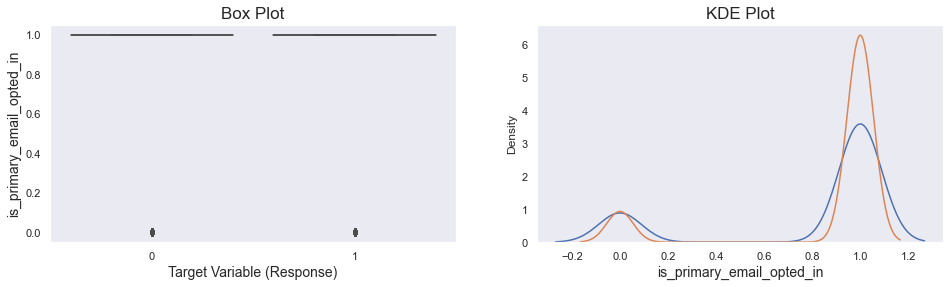

**2. Plot for is_aclu_voter**

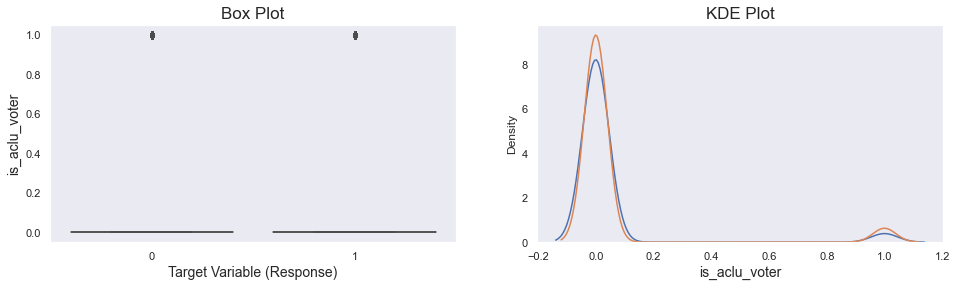

**3. Plot for is_donor**

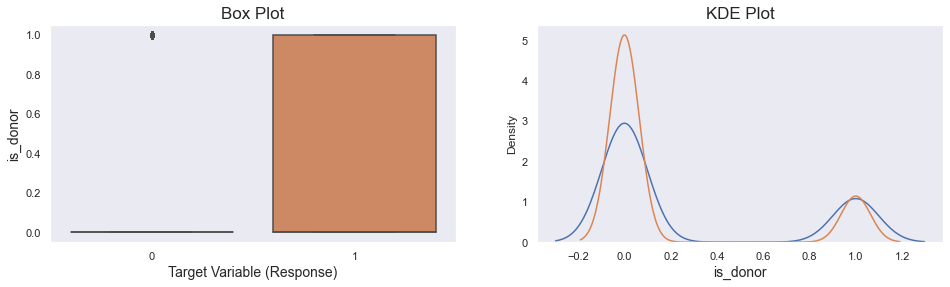

**4. Plot for is_supporter**

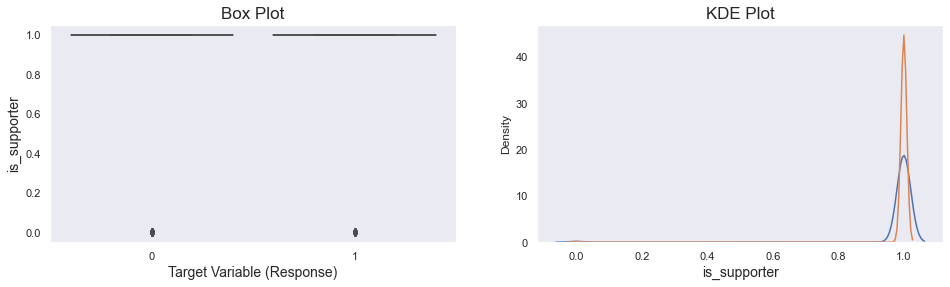

**5. Plot for is_email_subscriber**

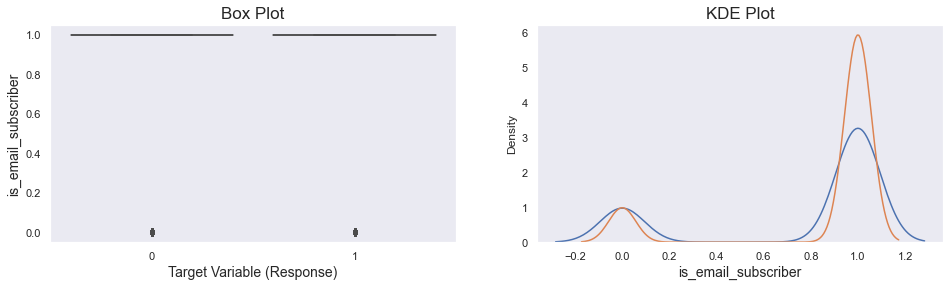

**6. Plot for is_action_taker**

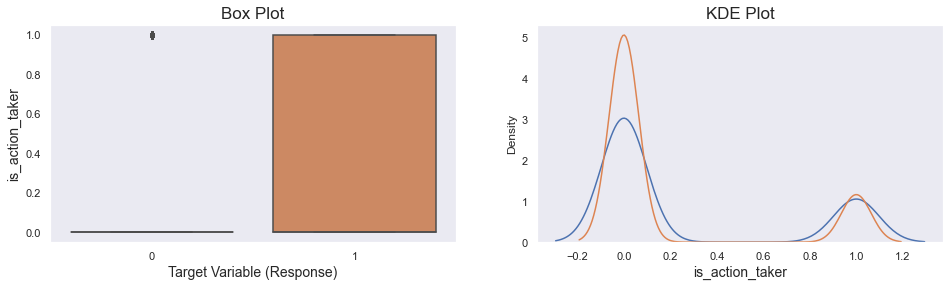

In [77]:
sns.set_style('dark')
df_data_sample = df_data.sample(n=10000)
print('Shape of Data Sample: {}'.format(df_data_sample.shape))
eda.numerical_plots_with_target(df_data_sample, variables=ls_numerical_columns, target='Response', model_type='clf')

Shape of Data Sample: (10000, 17)


**<u> 1. Plot for mailing_name_recieved</u>**

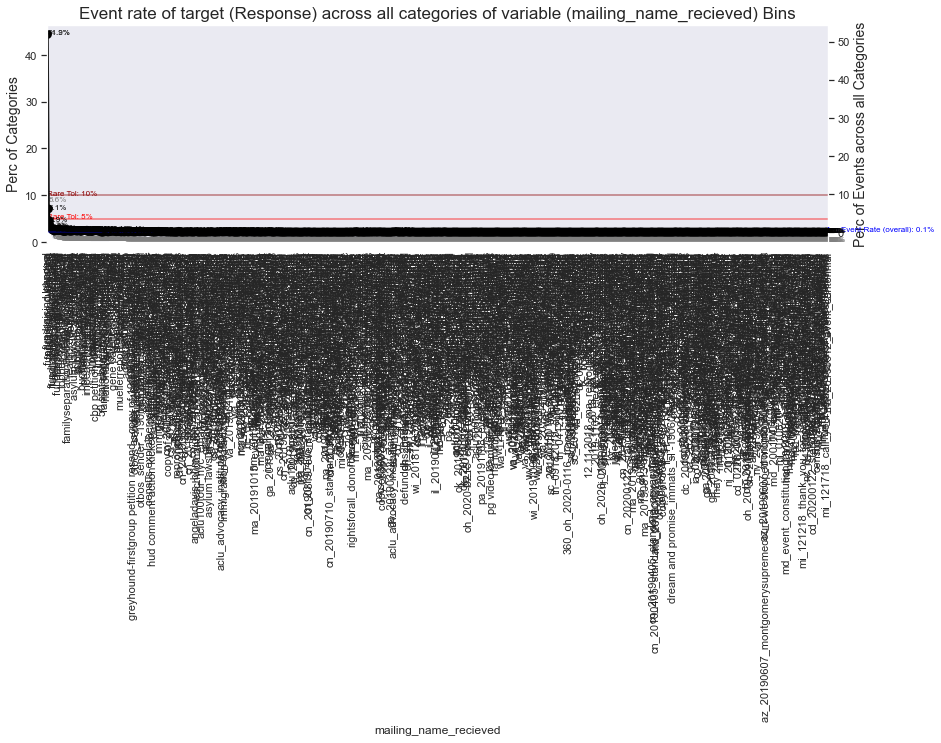

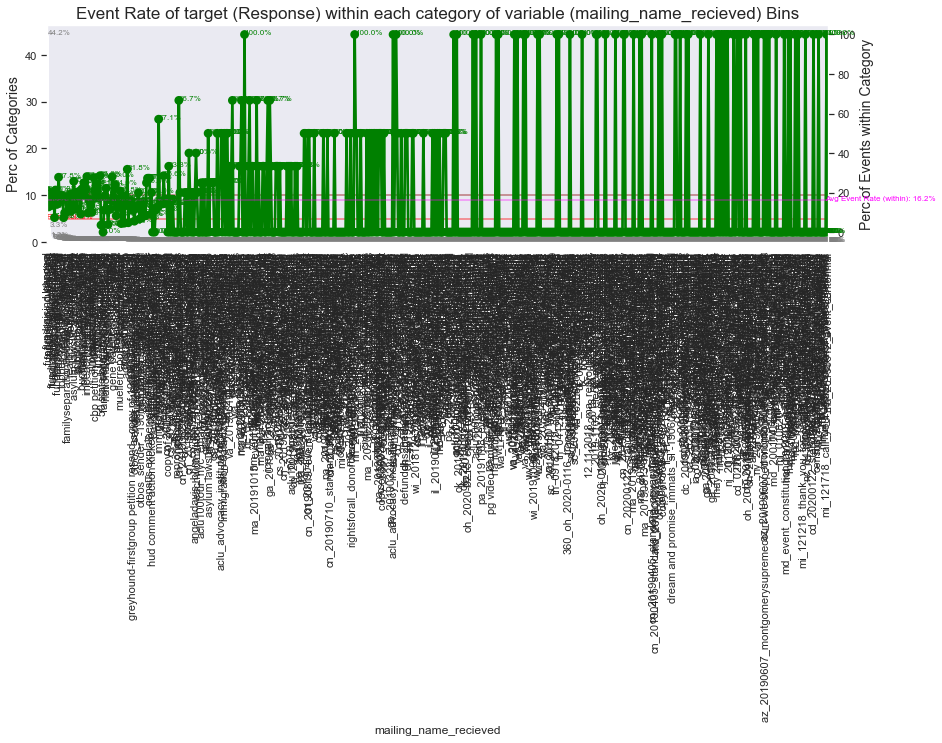

**<u> 2. Plot for gender</u>**

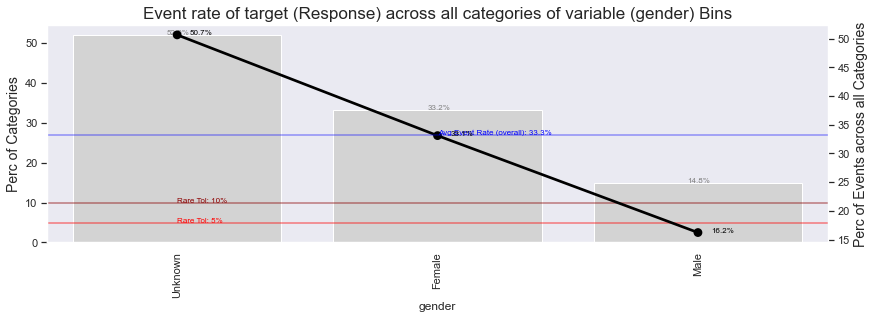

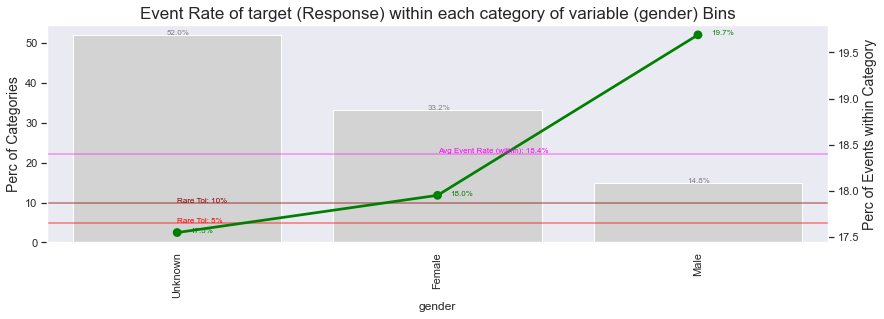

**<u> 3. Plot for mailing_country</u>**

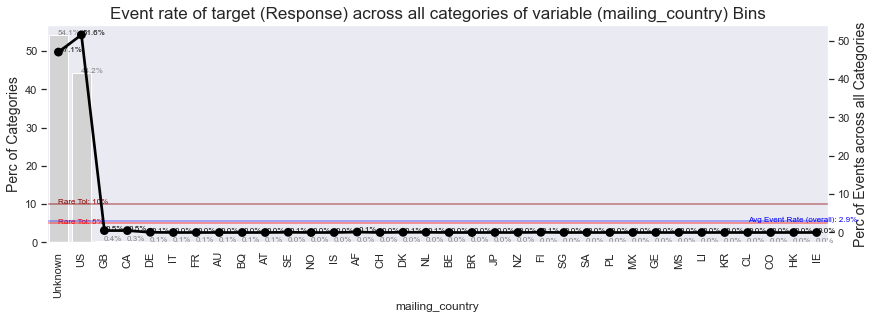

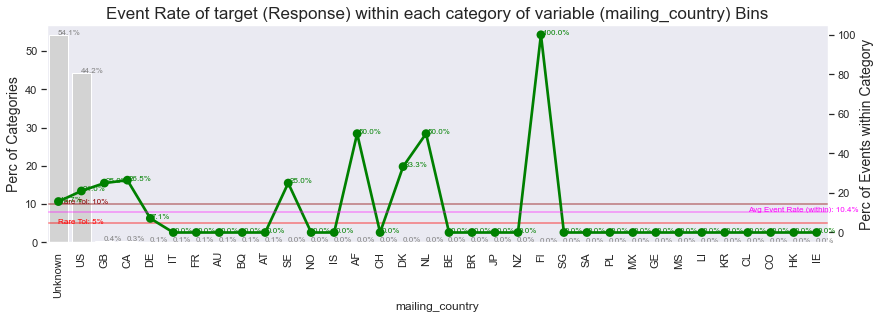

**<u> 4. Plot for mailing_state</u>**

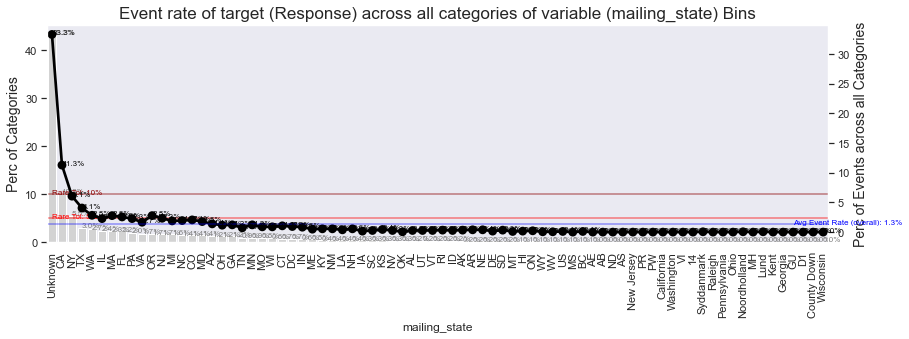

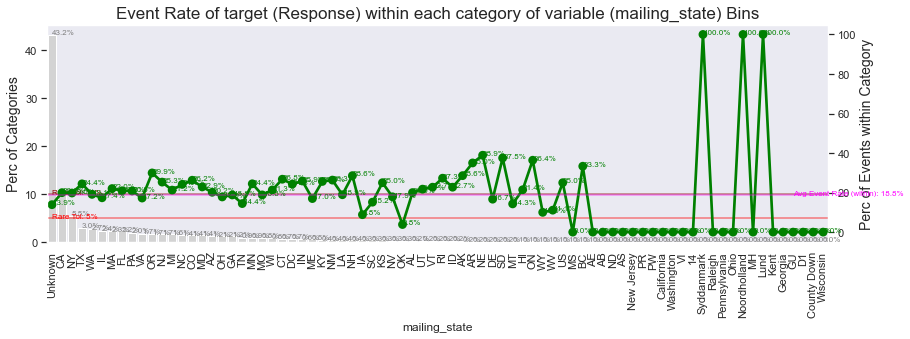

**<u> 5. Plot for party_affiliation</u>**

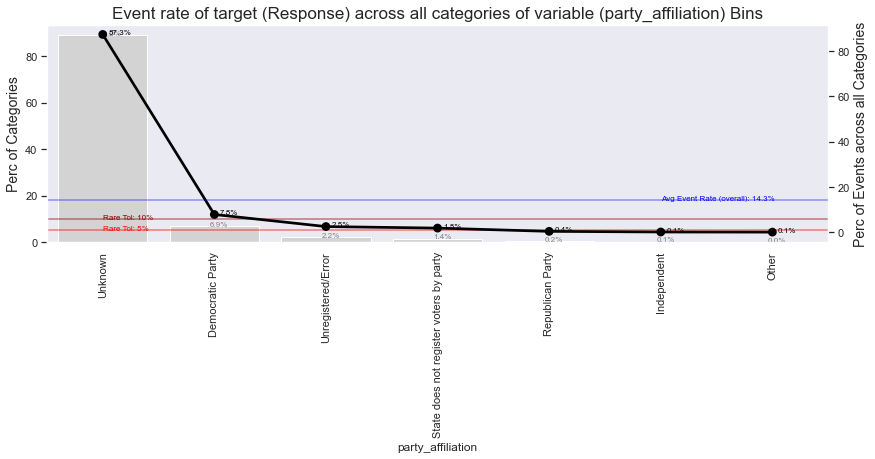

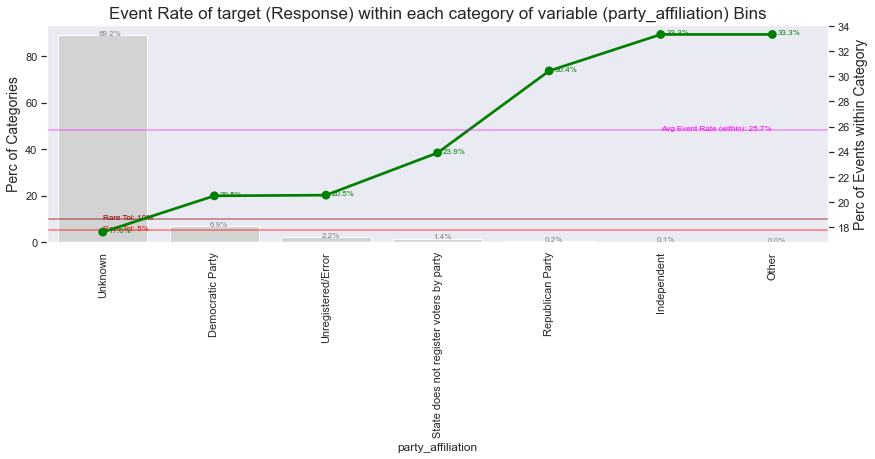

**<u> 6. Plot for voting_likelihood</u>**

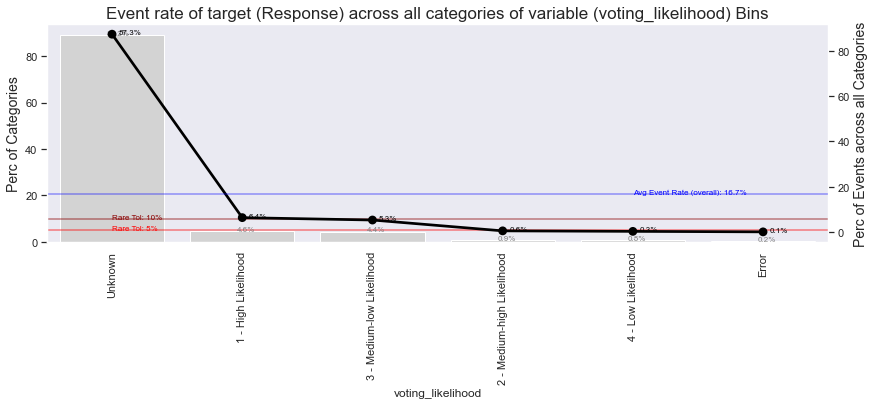

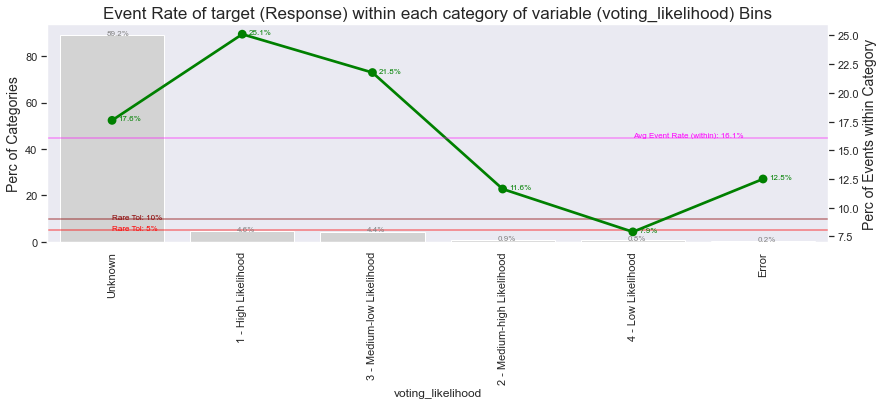

In [78]:
sns.set_style('dark')
df_data_sample = df_data.sample(n=10000)
print('Shape of Data Sample: {}'.format(df_data_sample.shape))
eda.categorical_plots_with_target(df_data_sample, variables=ls_categorical_columns, target='Response', model_type='clf')

The above EDA shows us that there is signal in the dependent variables. The event rate in the categorical variables seems to indicate a little bit of bias from a country standpoint for e.g., however there is nothing out of the ordinary.

There is a lot happening in the above pairplot. However, how do we say there is a signal.
- The key for us is the distribution of the variables in question split by our response/dependent variable.
- What we don't want to see is that distribution of the variable in question for the response variable is very close to each other or worse, exactly the same since. Why is that?

The histograms of the two variables plotted against our response variables makes it clear that these distributions are different. **Why is this important?** If we recally simple hypothesis testing, the difference in means of the distributions would indicate there is some signal in the system to reject the null hypothesis. 

The difference in distributions for the subset of variables we've considered in the pair plot w.r.t to the response/dependent variable (the diagonals) seems to signal there is some signal for response/dependent variable. 

Whether it is significant or not, we can understand by further modeling and transforming the data later. 

Given the above EDA, we can subset the columns/variables for our analysis in the main dataset to as shown below:

In [79]:
ls_cols_subset = ls_datetime_columns + ls_categorical_columns + ls_numerical_columns + ['Response']
df_data = df_data[ls_cols_subset]
df_data.head()

,created_date,mailing_name_recieved,gender,mailing_country,mailing_state,party_affiliation,voting_likelihood,is_primary_email_opted_in,is_aclu_voter,is_donor,is_supporter,is_email_subscriber,is_action_taker,Response
0,2017-02-26,Unknown,Unknown,US,NY,Unknown,Unknown,1.0000,0,0,1,1,1,0
1,2017-02-26,Unknown,Unknown,US,NY,Unknown,Unknown,1.0000,0,0,1,1,1,0
2,2017-02-26,Unknown,Unknown,US,NY,Unknown,Unknown,1.0000,0,0,1,1,1,0
3,2017-02-26,Unknown,Unknown,US,NY,Unknown,Unknown,1.0000,0,0,1,1,1,0
4,2017-02-26,Unknown,Unknown,US,NY,Unknown,Unknown,1.0000,0,0,1,1,1,0


### Variance Inflation and Multicollinearity

Another important aspect to consider is multicollinearity. We want our independent variables that are correlated to the dependent variable to explain it, however, we don't correlation of the independent variables amongst themselves. **Why is this important?** If we have two independent variables that explain the dependent/response variable, and the variance between them is very similiar ,why not just use one of them that explains the dependent variable better.

We can find this by plotting a correlation matrix and visualize it using a heatmap. Assuming a correlation threshold of 0.5

In [80]:
d_corr_threshold = 0.5
df_data_corr = df_data.corr()
eda.numerical_describe(df_data_corr)

,count,mean,std,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,100%
is_primary_email_opted_in,7.0000,0.2861,0.4693,-0.0832,-0.0284,0.0114,0.0210,0.0341,0.0488,0.0596,0.2410,0.7638,0.9628,0.9814,1.0000
is_aclu_voter,7.0000,0.1155,0.3946,-0.1175,-0.1119,-0.0922,-0.0446,-0.0121,0.0127,0.0197,0.0246,0.0255,0.4155,0.7077,1.0000
is_donor,7.0000,0.1765,0.3707,-0.1081,-0.0260,0.0327,0.0445,0.0486,0.0488,0.0675,0.0915,0.1261,0.4826,0.7413,1.0000
is_supporter,7.0000,0.1646,0.3697,-0.0198,-0.0072,0.0035,0.0104,0.0192,0.0288,0.0492,0.0636,0.0659,0.4400,0.7200,1.0000
is_email_subscriber,7.0000,0.2844,0.4709,-0.0980,-0.0310,0.0161,0.0234,0.0349,0.0485,0.0571,0.2379,0.7630,0.9628,0.9814,1.0000
is_action_taker,7.0000,0.1592,0.3787,-0.1175,-0.0463,0.0026,0.0068,0.0104,0.0136,0.0482,0.0846,0.1243,0.4826,0.7413,1.0000
Response,7.0000,0.1316,0.3890,-0.0980,-0.0891,-0.0723,-0.0396,-0.0252,-0.0198,0.0348,0.0730,0.0783,0.4480,0.7240,1.0000


<AxesSubplot:>

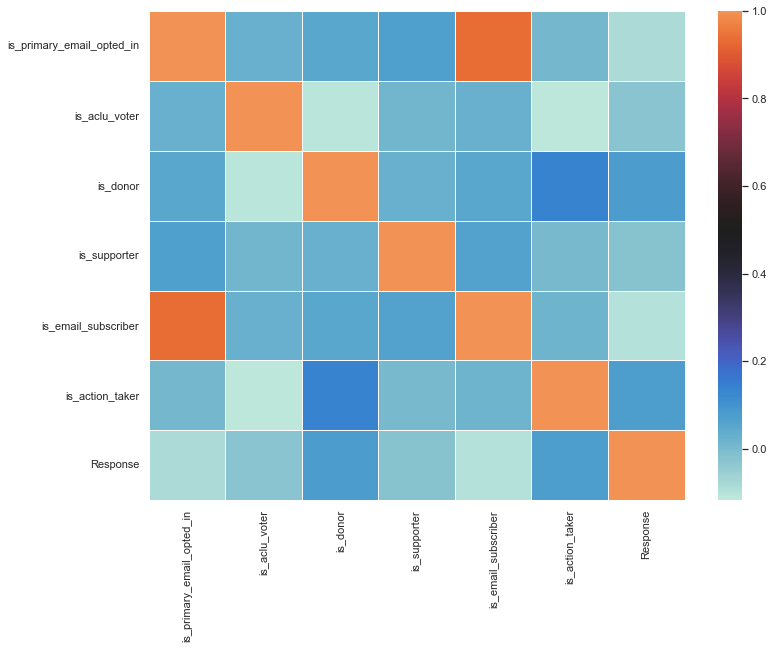

In [81]:
sns.set_style('dark')
# sns.heatmap(df_data_corr, center=eda.numerical_describe(df_data_corr)['50%'].mean(), linewidths=.5)
sns.heatmap(df_data_corr, center=d_corr_threshold, linewidths=.5)

In [82]:
print('Number of Columns: {}'.format(len(df_data_corr.columns)))
df_data_corr.columns

Number of Columns: 7


Index(['is_primary_email_opted_in', 'is_aclu_voter', 'is_donor',
       'is_supporter', 'is_email_subscriber', 'is_action_taker', 'Response'],
      dtype='object')

The heatmap gives us good insights here. It shows us the variables are not that correlated with each other as much.

In [83]:
# df_data_corr_unstack = df_data_corr[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
#                                      'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 
#                                      'NumCatalogPurchases', 'NumStorePurchases', 'Response']].unstack()
# df_data_corr_sort = df_data_corr_unstack.sort_values(kind="quicksort").to_frame()
# df_data_corr_sort.columns = ['correlation']
# df_data_corr_sort_vars = df_data_corr_sort[(df_data_corr_sort['correlation']>d_corr_threshold) & (df_data_corr_sort['correlation']<1)]
# df_data_corr_sort_vars = df_data_corr_sort_vars.reset_index().sort_values(kind="quicksort", by='level_0').drop_duplicates(subset='correlation').reset_index(drop=True)
# df_data_corr_sort_vars.columns = ['var_1','var_2','var_correlation']

# df_data_corr_sort_response = df_data_corr_sort.reset_index()
# df_data_corr_sort_response = df_data_corr_sort_response[df_data_corr_sort_response['level_0'] == 'Response']
# df_data_corr_sort_response = df_data_corr_sort_response.sort_values(kind="quicksort", by='level_1').drop_duplicates(subset='correlation').reset_index(drop=True)
# df_data_corr_sort_response.columns = ['response','response_var','response_var_correlation']

# df_merge = pd.merge(left=df_data_corr_sort_vars, right=df_data_corr_sort_response, how='inner', left_on=['var_1'], right_on=['response_var'])
# df_merge = df_merge.rename(columns={'response_var_correlation':'response_var_1_correlation'})
# df_merge = pd.merge(left=df_merge, right=df_data_corr_sort_response, how='inner', left_on=['var_2'], right_on=['response_var'])
# df_merge = df_merge.rename(columns={'response_var_correlation':'response_var_2_correlation'})
# df_merge = df_merge.drop(columns=['response_x','response_var_x','response_y','response_var_y'])

# # Keep the variable that has higher correlation / covariance with the response variable
# df_merge['vars_to_keep'] = df_merge.apply(lambda x: x['var_1'] if x['response_var_1_correlation'] > x['response_var_2_correlation'] else x['var_2'], axis=1)
# df_merge

Sanity check the dependent variable and independent variable collection. 
- Is it practical? For e.g. we are not using any features that are dependent on the future. 
- Can we explain it to the business in simple terms?

## Model Building:

### Split the data into Training, Validation and Test sets
- 80:20 split between training and testing data
- Split the data before doing any sort of pre-processing into test, valid and training data for a given response variable
    - Train:Valid:Test = 80%:1%:19%
    - This is just so we will never use the Valid data and just use the Test data for predicting / evaluating the model

In [84]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_data, target = 'Response', train_size=0.8, valid_size=0.001, test_size=0.199)

# Get the shape of all the datasets
print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of Y_train: {}'.format(y_train.shape))
print('Shape of X_valid: {}'.format(X_valid.shape))
print('Shape of Y_valid: {}'.format(y_valid.shape))
print('Shape of X_test: {}'.format(X_test.shape))
print('Shape of Y_test: {}'.format(y_test.shape))

Shape of X_train: (6084364, 13)
Shape of Y_train: (6084364,)
Shape of X_valid: (7605, 13)
Shape of Y_valid: (7605,)
Shape of X_test: (1513487, 13)
Shape of Y_test: (1513487,)


In [85]:
X_train.head()

,created_date,mailing_name_recieved,gender,mailing_country,mailing_state,party_affiliation,voting_likelihood,is_primary_email_opted_in,is_aclu_voter,is_donor,is_supporter,is_email_subscriber,is_action_taker
5149651,2017-04-28,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,0.0000,0,0,1,0,0
2644422,2017-02-08,nj_20190313_event_lightsoflibertydinner,Female,US,NJ,Unregistered/Error,3 - Medium-low Likelihood,0.0000,0,0,1,0,0
1528616,2017-02-21,Unknown,Male,US,DC,Unknown,Unknown,0.0000,0,0,1,0,0
65775,2017-02-26,Unknown,Female,US,CA,Unknown,Unknown,1.0000,0,0,1,1,0
5160891,2017-12-17,co_20191010_standard_reproductivefreedom,Unknown,Unknown,Unknown,Unknown,Unknown,1.0000,0,0,1,1,0


In [86]:
y_train.unique()

array([0, 1])

### Gather the Numerical and Categorical variable names

In [88]:
# Garner the numerical and categorical variables seperately
df_eda_X = eda.df_info(X_train)
ls_numerical_columns_X = list(df_eda_X[df_eda_X['data_type_grp'] == 'Numerical'].T.columns)
ls_categorical_columns_X = list(df_eda_X[df_eda_X['data_type_grp'] == 'Categorical'].T.columns)
ls_datetime_columns_X = list(df_eda_X[df_eda_X['data_type_grp'] == 'DateTime'].T.columns)

df_eda_X

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
created_date,datetime64[ns],DateTime,1119,"[1493337600000000000, 1486512000000000000, 148...",0,0.0000
mailing_name_recieved,object,Categorical,2240,"[Unknown, nj_20190313_event_lightsoflibertydin...",0,0.0000
gender,object,Categorical,3,"[Unknown, Female, Male]",0,0.0000
mailing_country,object,Categorical,113,"[Unknown, US, CA, IT, MX, AT, AZ, GB, AU, FR]",0,0.0000
mailing_state,object,Categorical,160,"[Unknown, NJ, DC, CA, GA, NH, ME, PA, TX, MN]",0,0.0000
party_affiliation,object,Categorical,7,"[Unknown, Unregistered/Error, Democratic Party...",0,0.0000
voting_likelihood,object,Categorical,6,"[Unknown, 3 - Medium-low Likelihood, 1 - High ...",0,0.0000
is_primary_email_opted_in,float64,Numerical,2,"[0.0, 1.0]",0,0.0000
is_aclu_voter,int64,Numerical,2,"[0, 1]",0,0.0000
is_donor,int64,Numerical,2,"[0, 1]",0,0.0000


In [89]:
print('Numerical Columns: {}'.format(ls_numerical_columns_X))
print('Categorical Columns: {}'.format(ls_categorical_columns_X))
print('Datetime Columns: {}'.format(ls_datetime_columns_X))

Numerical Columns: ['is_primary_email_opted_in', 'is_aclu_voter', 'is_donor', 'is_supporter', 'is_email_subscriber', 'is_action_taker']
Categorical Columns: ['mailing_name_recieved', 'gender', 'mailing_country', 'mailing_state', 'party_affiliation', 'voting_likelihood']
Datetime Columns: ['created_date']


### Feature Engineering - Categorical Variables

In [90]:
df_eda_X = eda.df_info(X_train)
ls_numerical_columns_X = list(df_eda_X[df_eda_X['data_type_grp'] == 'Numerical'].T.columns)
ls_categorical_columns_X = list(df_eda_X[df_eda_X['data_type_grp'] == 'Categorical'].T.columns)
ls_datetime_columns_X = list(df_eda_X[df_eda_X['data_type_grp'] == 'DateTime'].T.columns)

cat_encoder = FeatureEngineering_Categorical(method = 'label')

#Scikit-learn type fit() transform() functionality
# Use fit() only on the train dataset
cat_encoder.fit(X_train, ls_categorical_columns_X, rare_tol=5)

# Use transform() on train/test dataset
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

### Feature Engineering - Dates

In [91]:
dt_encoder = FeatureEngineering_DateTime(drop_orig=True)

#Scikit-learn type fit() transform() functionality
# Use fit() only on the train dataset
dt_encoder.fit(X_train, ls_datetime_columns_X, prefix = 'default')

# Use transform() on train/test dataset
X_train = dt_encoder.transform(X_train)
X_train.drop(labels=['created_date:day_part', 'created_date:time'], axis=1, inplace=True)
X_test = dt_encoder.transform(X_test)
X_test.drop(labels=['created_date:day_part', 'created_date:time'], axis=1, inplace=True)

### Feature Engineering - Numeric Variables: Data mapping to normal distribution and/or normalization and/or standardization

- If the numeric data is distributed normally, then it may help to standardize the variable to zero mean and unit variance.
- An alternative to standardization is Scaling features to a range
- Depending on the variable distribution, it may help to transform the variable into Gaussian distribution using a Power transformer
In our case, since we will be using a decision tree to model the response data and since decison trees are robust to scaling and outliers, so we will **ignore normalization/scaling** of Numeric variables.
- In this case we don't have much of numerical variables, since we didn't transform the email activity for features.

### Missing data handling and imputation
- We've already handle missing data in the beginning
- In a general sense, we'd like to impute the numerical and categorical data.
- For the purpose of a baseline model, we will leverage the generalized method to get to the model in the interest of time.
- When in doubt, leverage common sense for each variable or if you've a large enough sample of data, drop the rows that have missing data.

In [92]:
cat_imputer = MissingDataImputer_Categorical(method = 'frequent', add_indicator=False)

#Scikit-learn type fit() transform() functionality
# Use fit() only on the train dataset
cat_imputer.fit(X_train, ls_categorical_columns_X)
print('Parameters for the Imputer to fit for different categorical variables: {}'.format(cat_imputer.param_dict_))

# Use transform() on train/test dataset
X_train = cat_imputer.transform(X_train)
X_test = cat_imputer.transform(X_test)

Parameters for the Imputer to fit for different categorical variables: {'mailing_name_recieved': 0, 'gender': 0, 'mailing_country': 0, 'mailing_state': 0, 'party_affiliation': 0, 'voting_likelihood': 0}


In [93]:
num_imputer = MissingDataImputer_Numerical(method = 'median', add_indicator=False)

#Scikit-learn type fit() transform() functionality
# Use fit() only on the train dataset
num_imputer.fit(X_train, variables = ls_numerical_columns_X)
print('Parameters for the Imputer to fit for different numerical variables: {}'.format(num_imputer.param_dict_))

# Use transform() on train/test dataset
X_train = num_imputer.transform(X_train)
X_test = num_imputer.transform(X_test)

Parameters for the Imputer to fit for different numerical variables: {'is_primary_email_opted_in': 1.0, 'is_aclu_voter': 0.0, 'is_donor': 0.0, 'is_supporter': 1.0, 'is_email_subscriber': 1.0, 'is_action_taker': 0.0}


### Handling class imbalance in response variables
A quick look of our target/response variables shows pretty much a significant imbalance between
- Dependent variable = 1, implying if customer opened the email in the past campaigns and ends up being the minorty class.
- Dependent variable = 0, implying if customer opened the email in the past campaigns and ends up being the majority class.

<AxesSubplot:xlabel='Response', ylabel='Count'>

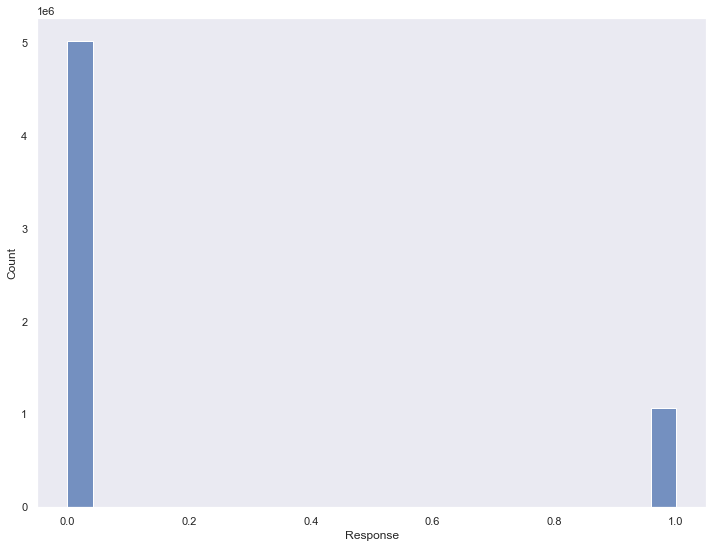

In [94]:
sns.histplot(y_train)

Class imbalance tends to skew our models real performance by misleading accuracy scores. A variety of techniques exist
- Undersampling the majority class, may lead to information loss.
- Oversampling the minority class, may lead to overfitting.

Different techniques can be tried off to optimize the model. However, in the interest of time we will use a BalanceRandomForestClassifier - BalancedRandomForestClassifier is another ensemble method in which each tree of the forest will be provided a balanced bootstrap sample. This class provides all functionality of the RandomForestClassifier, while helping us choose the sampling technique for each bootstrap level.

In [95]:
eda.df_info(X_train)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
mailing_name_recieved,int64,Numerical,2240,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,0.0000
gender,int64,Numerical,3,"[0, 1, 2]",0,0.0000
mailing_country,int64,Numerical,113,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,0.0000
mailing_state,int64,Numerical,160,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,0.0000
party_affiliation,int64,Numerical,7,"[0, 1, 2, 3, 4, 5, 6]",0,0.0000
voting_likelihood,int64,Numerical,6,"[0, 1, 2, 3, 4, 5]",0,0.0000
is_primary_email_opted_in,float64,Numerical,2,"[0.0, 1.0]",0,0.0000
is_aclu_voter,int64,Numerical,2,"[0, 1]",0,0.0000
is_donor,int64,Numerical,2,"[0, 1]",0,0.0000
is_supporter,int64,Numerical,2,"[1, 0]",0,0.0000


In [96]:
eda.df_info(X_test)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
mailing_name_recieved,float64,Numerical,2128,"[0.0, 4.0, 15.0, 286.0, 74.0, 83.0, 129.0, 28....",0,0.0000
gender,int64,Numerical,3,"[1, 0, 2]",0,0.0000
mailing_country,float64,Numerical,103,"[1.0, 0.0, 7.0, 8.0, 12.0, 5.0, 16.0, 29.0, 3....",0,0.0000
mailing_state,int64,Numerical,158,"[15, 0, 10, 26, 19, 12, 22, 27, 1, 3]",0,0.0000
party_affiliation,int64,Numerical,7,"[2, 0, 3, 1, 5, 4, 6]",0,0.0000
voting_likelihood,int64,Numerical,6,"[2, 0, 1, 5, 4, 3]",0,0.0000
is_primary_email_opted_in,float64,Numerical,2,"[0.0, 1.0]",0,0.0000
is_aclu_voter,int64,Numerical,2,"[0, 1]",0,0.0000
is_donor,int64,Numerical,2,"[0, 1]",0,0.0000
is_supporter,int64,Numerical,2,"[1, 0]",0,0.0000


### Classification

In [97]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0, sampling_strategy='not minority', oob_score=False, replacement=False, n_jobs=4)
brf.fit(X_train, y_train) 

y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.705518718181784

### Cross validation - Training Data

In [100]:
from sklearn.model_selection import cross_validate

scoring = ['precision', 'recall', 'accuracy', 'f1_weighted']
scores = cross_validate(brf, X_train, y_train, scoring=scoring, cv=3)
print('Scored for Training Data')
print('Scored for metrics: {}'.format(sorted(scores.keys())))
print('Accuracy: {}'.format(scores['test_accuracy']))
print('Recall: {}'.format(scores['test_recall']))
print('Precision: {}'.format(scores['test_precision']))
print('F1 Score: {}'.format(scores['test_f1_weighted']))

Scored for Training Data
Scored for metrics: ['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision', 'test_recall']
Accuracy: [0.71694454 0.71457226 0.71410088]
Recall: [0.68407057 0.6858592  0.68588439]
Precision: [0.34636022 0.34429471 0.34383678]
F1 Score: [0.74685914 0.74495933 0.74457297]


Cross validating for precision and recall, it is pretty good in the training set, given that we are modeling imbalanced data.

## Model Evaluation:

### Confusion Matrix - Training and Test Data

Confusion Matrix Report for the Training Data


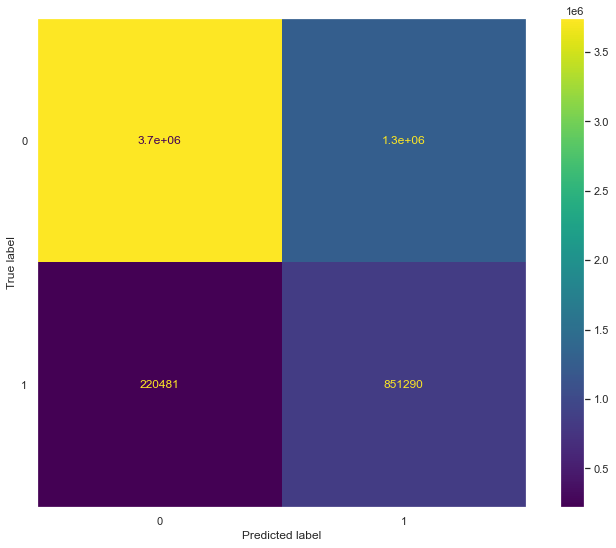

In [101]:
sns.set_style('dark')
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

y_pred = brf.predict(X_train)
target_names = ['Reponse 0', 'Response 1']
print('Confusion Matrix Report for the Training Data')
plot_confusion_matrix(brf, X_train, y_train)

Confusion Matrix Report for the Test Data


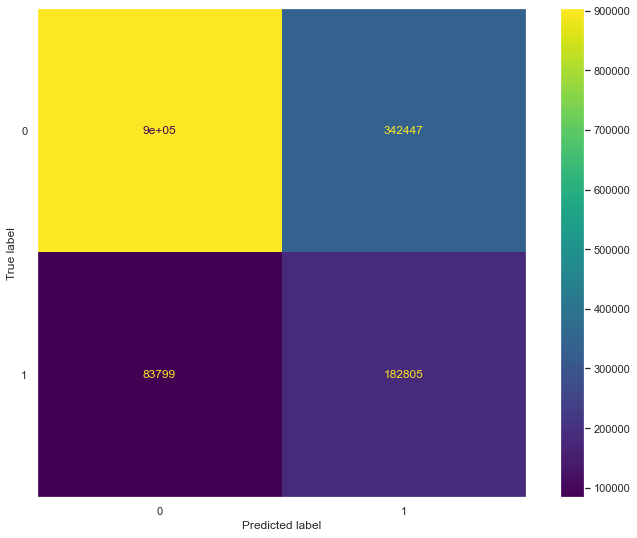

In [102]:
sns.set_style('dark')

y_pred = brf.predict(X_test)
target_names = ['Reponse 0', 'Response 1']
print('Confusion Matrix Report for the Test Data')
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(brf, X_test, y_test)

### Classification Report - Training and Test Data

In [103]:
from sklearn.metrics import classification_report

y_pred = brf.predict(X_train)
target_names = ['Reponse 0', 'Response 1']
print('Classification Report for the Training Data')
print(classification_report(y_train, y_pred, target_names=target_names))

Classification Report for the Training Data
              precision    recall  f1-score   support

   Reponse 0       0.94      0.75      0.83   5012593
  Response 1       0.40      0.79      0.53   1071771

    accuracy                           0.76   6084364
   macro avg       0.67      0.77      0.68   6084364
weighted avg       0.85      0.76      0.78   6084364



In [104]:
y_pred = brf.predict(X_test)
target_names = ['Reponse 0', 'Response 1']
print('Classification Report for the Test Data')
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report for the Test Data
              precision    recall  f1-score   support

   Reponse 0       0.92      0.73      0.81   1246883
  Response 1       0.35      0.69      0.46    266604

    accuracy                           0.72   1513487
   macro avg       0.63      0.71      0.64   1513487
weighted avg       0.82      0.72      0.75   1513487



### F1 score - Test Data

In [105]:
from sklearn.model_selection import cross_validate

scoring = ['precision', 'recall', 'accuracy', 'f1_weighted']
scores = cross_validate(brf, X_test, y_test, scoring=scoring, cv=3)
print('Scored for Test Data')
print('Scored for metrics: {}'.format(sorted(scores.keys())))
print('Accuracy: {}'.format(scores['test_accuracy']))
print('Recall: {}'.format(scores['test_recall']))
print('Precision: {}'.format(scores['test_precision']))
print('F1 Score: {}'.format(scores['test_f1_weighted']))

Scored for Test Data
Scored for metrics: ['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision', 'test_recall']
Accuracy: [0.70260022 0.70284799 0.70247079]
Recall: [0.67797182 0.67332448 0.67639645]
Precision: [0.33164712 0.33110703 0.33126853]
F1 Score: [0.73492104 0.73501266 0.73477663]


### ROC curve and threshold selection - Test and Training Data

In [106]:
from sklearn.metrics import roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix

def get_fp_tp_pp(y, proba, threshold):
    """Return the number of false positives and true positives, along with the confusion matrix."""
    # Classify into classes based on threshold
    y_pred = pd.Series(np.where(proba>=threshold, 1, 0), dtype='int64')
    
    # Create confusion matrix
    cfm = pd.DataFrame(confusion_matrix(y, y_pred)).rename(columns={0: 'pred_0', 1: 'pred_1'}, index={0: 'actual_0', 1: 'actual_1'})
    false_positives = cfm.loc['actual_0','pred_1']
    true_positives = cfm.loc['actual_1', 'pred_1']
    positive_predictions = cfm.loc[:,'pred_1'].sum()
    return false_positives, true_positives, positive_predictions, cfm

def plot_interactive_roc_curve(df, fpr, tpr, thresholds):
    fig = px.area(
        data_frame=df, 
        x=fpr, 
        y=tpr,
        hover_data=thresholds, 
        title='ROC Curve',
    )
    fig.update_layout(
        autosize=False,
        width=900,
        height=600,
        margin=dict(l=30, r=30, b=30, t=30, pad=4),
        title_x=.5, # Centre title
        hovermode = 'closest',
        xaxis=dict(hoverformat='.4f'),
        yaxis=dict(hoverformat='.4f')
    )
    hovertemplate = 'False Positive Rate=%{x}<br>True Positive Rate=%{y}<br>Threshold=%{customdata[0]:.4f}<extra></extra>'
    fig.update_traces(hovertemplate=hovertemplate)
    
    # Add dashed line with a slope of 1
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
    fig.show()
    
def plot_interactive_precision_recall_curve(df, precision, recall, thresholds):
    fig = px.area(
        data_frame=df, 
        x=recall, 
        y=precision,
        hover_data=thresholds, 
        title='Precision-Recall Curve'
    )
    fig.update_layout(
        autosize=False,
        width=900,
        height=600,
        margin=dict(l=30, r=30, b=30, t=30, pad=4),
        title_x=.5, # Centre title
        hovermode = 'closest',
        xaxis=dict(hoverformat='.4f'),
        yaxis=dict(hoverformat='.4f')
    )
    hovertemplate = 'Recall=%{x}<br>Precision=%{y}<br>Threshold=%{customdata[0]:.4f}<extra></extra>'
    fig.update_traces(hovertemplate=hovertemplate)

    fig.show()

In [107]:
# Predict probability for training data
proba = brf.predict_proba(X_train)[:,1]

# Find fpr, tpr & pp for thresholds
negatives = np.sum(y_train==0)
positives = np.sum(y_train==1)
columns = ['threshold', 'false_positive_rate', 'true_positive_rate']
inputs_roc_prc_train = pd.DataFrame(columns=columns, dtype=np.float)
thresholds = np.linspace(0, 1, 100)
for i, threshold in enumerate(thresholds):
    inputs_roc_prc_train.loc[i, 'threshold'] = threshold
    false_positives, true_positives, positive_predictions, cfm = get_fp_tp_pp(y_train, proba, threshold)
    inputs_roc_prc_train.loc[i, 'false_positive_rate'] = false_positives/negatives
    inputs_roc_prc_train.loc[i, 'true_positive_rate'] = true_positives/positives
    inputs_roc_prc_train.loc[i, 'precision'] = true_positives/positive_predictions
    inputs_roc_prc_train.loc[i, 'recall'] = true_positives/positives

inputs_roc_prc_train.fillna(method='ffill', inplace=True)    
inputs_roc_prc_train

,threshold,false_positive_rate,true_positive_rate,precision,recall
0,0.0000,1.0000,1.0000,0.1762,1.0000
1,0.0101,0.9199,1.0000,0.1886,1.0000
2,0.0202,0.8973,1.0000,0.1924,1.0000
3,0.0303,0.8791,1.0000,0.1956,1.0000
4,0.0404,0.8632,0.9999,0.1985,0.9999
...,...,...,...,...,...
95,0.9596,0.0012,0.1722,0.9679,0.1722
96,0.9697,0.0007,0.1503,0.9773,0.1503
97,0.9798,0.0003,0.1242,0.9872,0.1242
98,0.9899,0.0001,0.0954,0.9948,0.0954


In [108]:
# Plot ROC Curve for training data
plot_interactive_roc_curve(df=inputs_roc_prc_train, 
                           fpr='false_positive_rate', 
                           tpr='true_positive_rate', 
                           thresholds=['threshold'])

In [109]:
# Predict probability for Test data
proba = brf.predict_proba(X_test)[:,1]

# Find fpr & tpr for thresholds
negatives = np.sum(y_test==0)
positives = np.sum(y_test==1)
columns = ['threshold', 'false_positive_rate', 'true_positive_rate']
inputs_roc_prc_test = pd.DataFrame(columns=columns, dtype=np.float)
thresholds = np.linspace(0, 1, 50)
for i, threshold in enumerate(thresholds):
    inputs_roc_prc_test.loc[i, 'threshold'] = threshold
    false_positives, true_positives, positive_predictions, cfm = get_fp_tp_pp(y_test, proba, threshold)
    inputs_roc_prc_test.loc[i, 'false_positive_rate'] = false_positives/negatives
    inputs_roc_prc_test.loc[i, 'true_positive_rate'] = true_positives/positives
    inputs_roc_prc_test.loc[i, 'precision'] = true_positives/positive_predictions
    inputs_roc_prc_test.loc[i, 'recall'] = true_positives/positives

inputs_roc_prc_test.fillna(method='ffill', inplace=True)    
# Plot ROC Curve for test data
plot_interactive_roc_curve(df=inputs_roc_prc_test, 
                           fpr='false_positive_rate', 
                           tpr='true_positive_rate', 
                           thresholds=['threshold'])

The training AUC curve seems to indicate a little bit of on overfitting happening but when we look at th AUC for an out of bag/sample prediction on completely unseen test data, the AUC is not bad at all. Comparing and contrasting the AUC on both training and test data,
- Depending on what is important to the business, we can choose the threshold.
- For e.g., in a marketing campaign, 
    - We are really not too much worried about false positives, meaning the model says user would convert from a campaign, however in reality they don't. Worst case, we would have never realized revenues from the users anway.
    - As long as the incremental cost is zero, say for e.g. emails, and we are not fatigueing our customers, we should be good to go.
    - We do want to optimize for true positives, meaning the model says a user would convert from a campaign and in reality they do. We'd lose topline revenues otherwise.
    
We can go with a threshold of ~0.4694, at which point we have 70% True positive rate and 30% False positive rate.

### Precison recall curve and threshold selection - Test and Training Data

In [110]:
plot_interactive_precision_recall_curve(df=inputs_roc_prc_train, precision='precision', recall='recall', thresholds=['threshold'])

In [111]:
plot_interactive_precision_recall_curve(df=inputs_roc_prc_test, precision='precision', recall='recall', thresholds=['threshold'])

We see a similar story in the Precision - Recall curve as well. The training curve seems to indicate a little bit of on overfitting happening but when we look at it for an out of bag/sample prediction on completely unseen test data, the Precision - Recall curve is not bad at all. Recall is again, nothing but the True positive rate.
    
Given that we are thinking of a threshold ~0.45, we can find out how the precision fare against the True positive rate, by plotting the Precision, Recall and False Positve Rates against the threshold.

### ROC + Precison Recall Overlapped curve and threshold selection - Test Data

In [112]:
d_chosen_threshold = 0.4694

fig = px.line(inputs_roc_prc_test, x='threshold', y=['false_positive_rate', 'precision', 'recall'], 
              title='Thresold vs FPR vs Precision vs TPR (Recall)')

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    margin=dict(l=30, r=30, b=30, t=30, pad=4),
    title_x=.5, # Centre title
    hovermode = 'closest',
    xaxis=dict(hoverformat='.4f'),
    yaxis=dict(hoverformat='.4f'),
)

fig.add_shape(type="line",
    xref="x", yref="y",
    x0=d_chosen_threshold, y0=0, x1=d_chosen_threshold, y1=1,
    line=dict(
        color="black",
        width=1,
        dash="dashdot"
    ),
)
fig.show()

When we plot the TPR, FPR and Precision against each other, by choosing a threshold of 0.4694 we are getting a decent amount of precison at 35%, along with 70% True positive rate and 30% False positive rate.

### Feature Importance - Classifier

In [113]:
df_feature_importance = pd.concat([pd.Series(brf.feature_importances_, name='feature_importance'), pd.Series(brf.feature_names_in_, name='feature_names')],axis=1)
df_feature_importance.sort_values(by='feature_importance', ascending=True, inplace=True)

fig = px.bar(df_feature_importance, x="feature_importance", y="feature_names")

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    margin=dict(l=30, r=30, b=30, t=30, pad=4),
    title_x=.5, # Centre title
    hovermode = 'closest',
    xaxis=dict(hoverformat='.4f'),
    yaxis=dict(hoverformat='.4f'),
)
fig.show()

## Recommendations:

We've fixed a threshold. Our model seems legit in test data in that it is better than way better than random, but what does this all mean for the business of marketing to users.

Now let's say, I come to you and say,
   - Imagine there are a list of 20 customers out there, in the real world, 10 who'll respond to our email campaigns and 10 who won't.
   - Say, for these customers, we know mailing name, mailing_state, gender, Date contact was created in our systems.


You say, sure here you go, let me give you that. Now what if I say,
   - I can point you to the customers who will open our next email campaign to them, **before** you actually run any campaigns.
   - Further more, I can correctly point you to 7 out of those 10 customers, who'll open the emails, right now **before** you actually run any campaigns.
   - Wouldn't that be pretty valuable?
   - Imagine the amount of unwanted emails we won't be sending out and the lessening of fatigue that would cause.

Further more,
   - Imagine I make 10 predictions, about customers, whether they will open our emails or not.
   - ~4 in 10 folks who were predicted to open our emails, will correctly do so.

Wouldn't that be cool :)?